In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
# Data Visualization 
import plotly.express as px
import random
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-09-07 05:17:20.507915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 05:17:20.508009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 05:17:20.639998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Organization
The study employs a comprehensive dataset consisting of images of skin lesions, specifically focusing on identifying monkeypox infections. The dataset is meticulously organized into three distinct sets to facilitate the training, validation, and evaluation phases of the machine learning model. Each set is stored in a separate directory, ensuring a streamlined process for model development and testing. The directory paths for these datasets are as follows:

Training Set: The training set, essential for the initial training of the neural network, is located at /kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train/. This dataset comprises a diverse collection of lesion images used to teach the model the characteristics of monkeypox infections.

Validation Set: The validation set, used to tune the model's hyperparameters and prevent overfitting, is found at /kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/. Periodic evaluation of the model on this dataset during training allows for adjustments before final testing, ensuring the model generalizes well to new data.

Test Set: The test set, crucial for evaluating the model's performance on unseen data, is stored at /kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Test/. This final evaluation provides an unbiased assessment of the model's ability to classify new images accurately, reflecting its potential effectiveness in real-world applications.

The division of the dataset into training, validation, and testing sets is a standard practice in machine learning and deep learning projects. It ensures that the model can learn from a variety of examples, adjust to prevent overfitting, and finally, be tested to provide an accurate measure of its performance. This structured approach to dataset organization is crucial for developing robust and reliable predictive models.

In [5]:
train_dir = "/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train/"
val_dir = "/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/"
test_dir = "/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Test/"

# Data Description and Preliminary Exploration

To facilitate a comprehensive analysis of the monkeypox skin lesion dataset, the study leverages a metadata file that contains detailed information about each image within the dataset. This metadata file, named Monkeypox_Dataset_metadata.csv, is pivotal for understanding the characteristics and annotations of the images. The acquisition of this metadata is accomplished through the utilization of the Pandas library, a powerful data manipulation tool in Python, which provides efficient and straightforward methods for handling structured data.

In [4]:
info_file = '/kaggle/input/monkeypox-skin-lesion-dataset/Monkeypox_Dataset_metadata.csv'
info = pd.read_csv(info_file)
info.head()

,ImageID,Label
0,M01_01,Monkeypox
1,M01_02,Monkeypox
2,M01_03,Monkeypox
3,M01_04,Monkeypox
4,M02_01,Monkeypox


# Data Preparation

Image Dataset Construction
To develop and evaluate the machine learning model for classifying skin lesions as indicative of monkeypox or not, the study employed high-resolution images from a structured dataset. The images were organized into separate directories for training, validation, and testing, facilitating a streamlined workflow for model development and evaluation. A crucial step in preparing these images for input into the neural network involved resizing and batching the images, operations that were performed using TensorFlow, a comprehensive open-source platform for machine learning.

In [6]:
# The dimensions for resizing the images were standardized to 224 by 224 pixels, a common resolution for convolutional neural network (CNN)
# inputs due to its balance between detail retention and computational efficiency. This size standardization ensures that the input layer of the CNN receives uniformly sized images, which is critical for the learning process.
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

Found 2142 files belonging to 2 classes.
Found 45 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


# Exploratory Data Analysis

Visualization of Class Distribution
A crucial step in the exploratory analysis of the dataset involved assessing the distribution of images across different classes. This assessment aimed to identify any imbalance in the dataset that could potentially bias the machine learning model's training and evaluation processes. To facilitate this analysis, a custom Python function, visualize_class_distribution, was developed and employed. This function automates the process of calculating and visualizing the number of images available for each class within the dataset.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


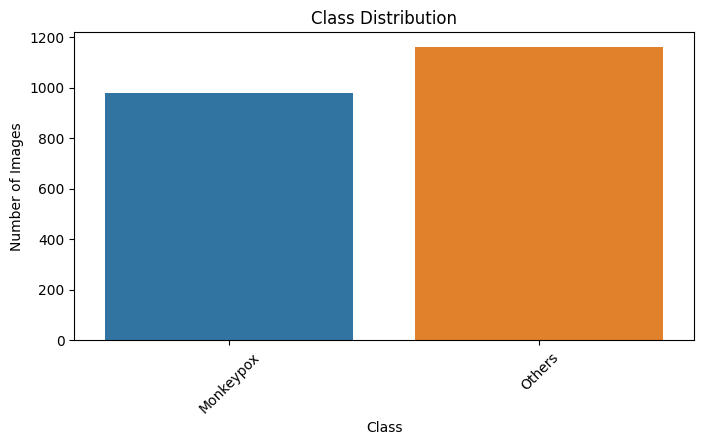

In [7]:
# Function to visualize class distribution
def visualize_class_distribution(data_dir):
    labels = os.listdir(data_dir)
    num_images_per_class = []

    for label in labels:
        label_dir = os.path.join(data_dir, label)
        num_images_per_class.append(len(os.listdir(label_dir)))

    # Plotting class distribution
    plt.figure(figsize=(8, 4))
    sns.barplot(x=labels, y=num_images_per_class)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

# Perform class distribution visualization
visualize_class_distribution(train_dir)

The visualize_class_distribution function takes a single parameter, data_dir, which specifies the directory path containing the dataset's image classes. Within this directory, each class's images are expected to be stored in separate subdirectories, named according to the class they represent. The function performs the following operations:

Class Identification: It identifies the available classes by listing the directories within data_dir. Each directory name is treated as a class label.

Image Counting: For each class, the function counts the number of images by listing the files within each class's corresponding subdirectory. This count represents the total number of images available for that class.

Data Visualization: Using Matplotlib and Seaborn libraries, the function then creates a bar plot to visualize the class distribution. The x-axis of the plot represents the class labels, while the y-axis indicates the number of images per class. Additional plot settings, such as figure size, title, axis labels, and x-axis tick rotation, are applied to enhance readability and presentation.

In [34]:
#fig = px.pie(
#    names=info.Label.unique(),
#    values=info.Label.value_counts(),
#    hole=0.2,
#    width=500,
#    height=500
#)
#fig.update_layout({'title':{'text':'Class Distribution','x':0.45}})
#fig.show()

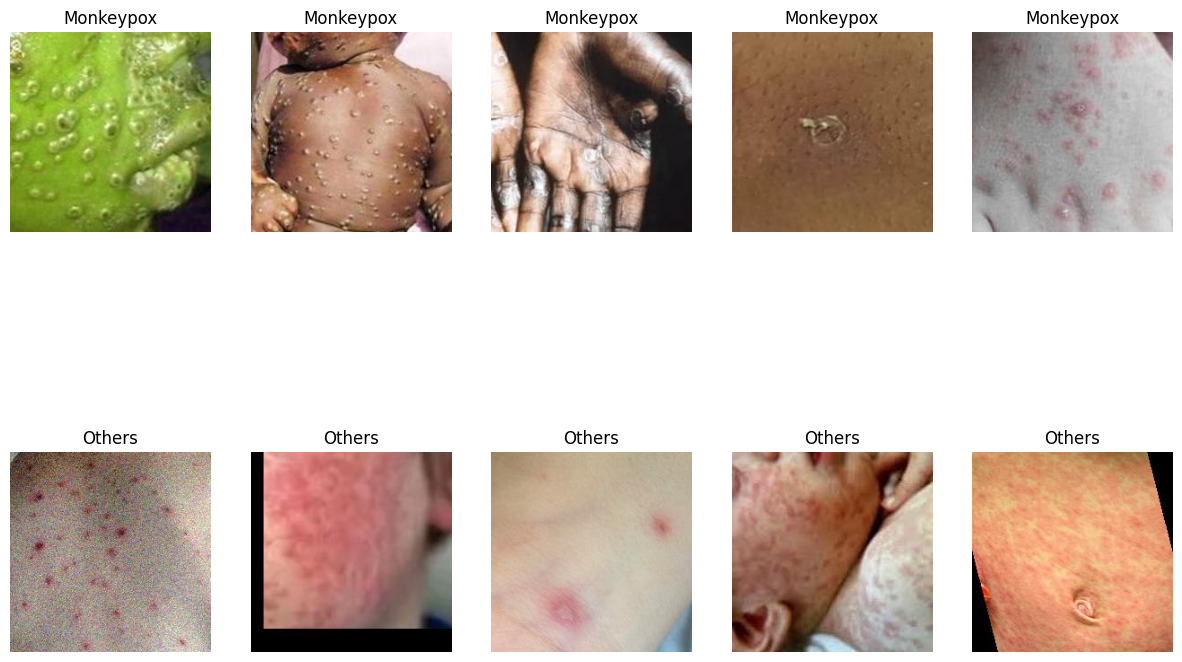

In [8]:
# Function to display additional sample images
def display_additional_samples(data_dir, num_samples=5):
    labels = os.listdir(data_dir)

    plt.figure(figsize=(15, 10))
    for i, label in enumerate(labels):
        label_dir = os.path.join(data_dir, label)
        images = os.listdir(label_dir)[:num_samples]
        for j, image in enumerate(images):
            plt.subplot(len(labels), num_samples, i * num_samples + j + 1)
            img = plt.imread(os.path.join(label_dir, image))
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
    plt.show()

# Display additional sample images
display_additional_samples(train_dir)

**Methodology for Sample Visualization**
to enhance the understanding of the dataset's characteristics and ensure a comprehensive exploratory data analysis, a Python function, display_additional_samples, was developed and implemented. This function is designed to systematically display a specified number of sample images from each class present in the dataset. Such visualization aids in assessing the variability within and between classes, crucial for informing subsequent data preprocessing and model training strategies.

In [9]:
# Visualizing data
def visualize_random_images(dataset_type="train", label_type="Others"):
    
    sample = 9
    
    plt.figure(figsize=(15, 8))
    type_dir = train_dir if dataset_type=="train" else test_dir
    base_dir = os.path.join(type_dir, label_type)
    images = random.sample(os.listdir(base_dir), 9)
    
    for i, image in enumerate(images):
        plt.subplot(3, 3, i+1)
        img = plt.imread(os.path.join(base_dir, image))
        plt.imshow(img)

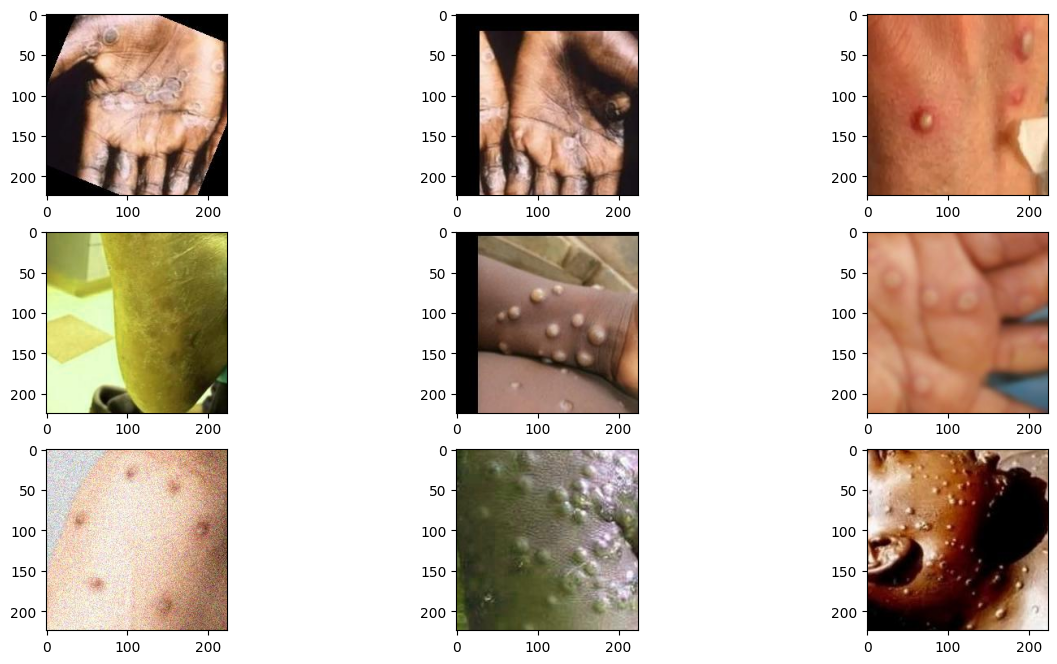

In [37]:
visualize_random_images("train", "Monkeypox")

In [12]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Function Implementation
The plot_loss_curves function leverages the TensorFlow model's History object, which records performance metrics at successive epochs during the model's training process. The History object encapsulates detailed logs of loss and accuracy metrics, facilitating a comprehensive analysis of the model's training journey. The visualization process is delineated as follows:

Metric Extraction: The function extracts the history of loss (loss, val_loss) and accuracy (accuracy, val_accuracy) metrics from the provided History object. These metrics represent the model's performance on the training and validation datasets across all epochs.

Epoch Enumeration: The epochs during which the model was trained are enumerated, providing a temporal axis for the performance plots.

Loss Visualization: A plot is generated to visualize the training and validation loss over epochs. This plot elucidates the model's optimization trajectory, highlighting how closely the model learns to predict the training data while generalizing to unseen validation data.

Accuracy Visualization: In a separate plot, training and validation accuracy metrics are visualized over epochs. This plot showcases the model's improving prediction capabilities as training progresses, offering insights into the model's efficacy in correctly classifying the data.

The dual plots of loss and accuracy serve as fundamental indicators of the model's training and validation performance, enabling the identification of key training phases such as rapid learning, plateauing of performance, or the onset of overfitting.

In [13]:
#The EfficientNetB3 model is initialized with the include_top=False parameter to exclude the original top layers (i.e., the fully connected layers) intended for classification. This exclusion allows for the adaptation of the model to our specific task requirements. 
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

#Input Layer: An input layer is defined to accommodate images of shape 224x224 pixels with 3 color channels, matching the input dimensions expected by EfficientNetB3.
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
#Dropout Layer 1: A dropout layer with a rate of 0.5 follows, introduced to mitigate overfitting by randomly omitting a portion of feature detectors during training.
dropout_layer_1 = layers.Dropout(0.5)(base_layer)
#Flattening Layer: The feature maps are then flattened, transforming the 2D feature maps into a 1D vector suitable for the dense layers.
flat_layer = layers.Flatten()(dropout_layer_1)
#Dense Layer 1: A dense layer with 256 neurons and ReLU activation function is employed to learn high-level patterns from the flat feature vector.
dense_1 = layers.Dense(256, activation="relu")(flat_layer)
#Dropout Layer 2: Another dropout layer with a rate of 0.5 is applied after the first dense layer to further prevent overfitting.
dropout_layer_2 = layers.Dropout(0.5)(dense_1)
#Dense Layer 2: Subsequently, a second dense layer with 128 neurons and ReLU activation follows, aimed at refining the learned representations.
dense_2 = layers.Dense(128, activation="relu")(dropout_layer_2)
#Output Layer: The final layer is a dense layer with a single neuron and a sigmoid activation function, designed to output the probability of the image belonging to the target class.
outputs = layers.Dense(1, activation="sigmoid")(dense_2)
model = Model(inputs, outputs)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Model Architecture
Incorporation of EfficientNetB3 as a Base Model
To harness the advantages of pre-trained models for our image classification task, the study employs the EfficientNetB3 architecture, sourced from TensorFlow's Keras applications module. EfficientNetB3 is renowned for its efficiency and effectiveness in balancing model depth, width, and resolution, making it a prime candidate for serving as the foundational layer of our customized neural network.

In [14]:
#Optimizer: The Adam optimizer was chosen due to its effectiveness in handling sparse gradients and its adaptability in adjusting the learning rate during training. The initial learning rate was set to 0.001, a value commonly used as a starting point for many types of neural networks.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Model Fitting
#Following the model's compilation, it underwent a training process using the training dataset (train_data) with validation performed on a separate dataset (val_data). The training was conducted over 20 epochs, allowing the model to iteratively learn from the training data while its performance was simultaneously evaluated on the validation data to monitor for overfitting.
history = model.fit(train_data,
                    epochs=20,
                    validation_data=val_data)

Epoch 1/20
 2/67 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.4922 - loss: 1.3919    

I0000 00:00:1725686380.571839     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 125s 966ms/step - accuracy: 0.7338 - loss: 1.3909 - val_accuracy: 0.8214 - val_loss: 0.5344
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9055 - loss: 0.4718 - val_accuracy: 0.8071 - val_loss: 0.9510
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9289 - loss: 0.3256 - val_accuracy: 0.8690 - val_loss: 0.6317
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9604 - loss: 0.1905 - val_accuracy: 0.8190 - val_loss: 0.8530
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9482 - loss: 0.2363 - val_accuracy: 0.8595 - val_loss: 0.5932
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9675 - loss: 0.1290 - val_accuracy: 0.8690 - val_loss: 0.8983
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9630 - loss: 0.1500 - val_accuracy: 0.8833 - val_loss: 0.7265
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9769 - loss: 0.1034 - val_accuracy: 0.8929 - val_loss:

# Model Training and Optimization
Compilation of the Neural Network Model
prior to training, the neural network model was compiled with specific configurations to optimize its performance for the binary classification task. The compilation process involved the selection of an optimizer, a loss function, and metrics for evaluating the model's performance.

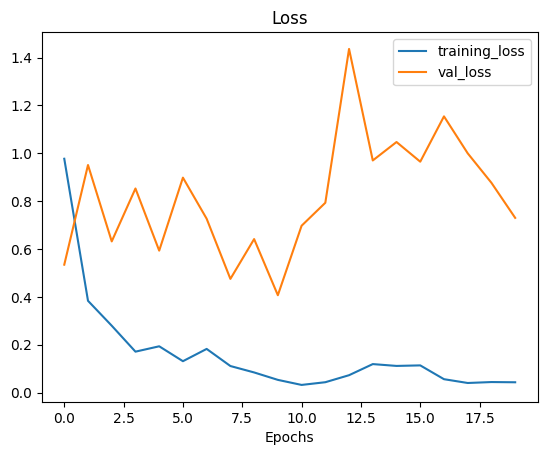

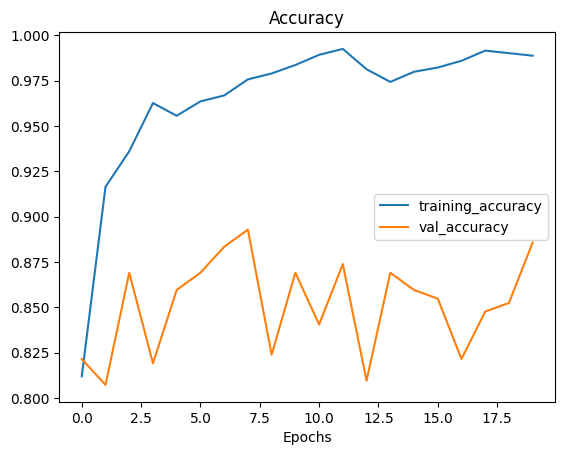

In [15]:
plot_loss_curves(history)

In [16]:
model.evaluate(test_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 8s/step - accuracy: 0.8843 - loss: 1.5673  


[1.2109198570251465, 0.8888888955116272]

In [17]:
y_pred = tf.math.round(model.predict(test_data))
y_true = []
for images, labels in test_data.unbatch():
  y_true.append(labels.numpy())

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step


In [18]:
accuracy_score(y_true, y_pred)

0.8888888888888888

In [19]:
print(classification_report(y_true, y_pred, target_names=train_data.class_names))

              precision    recall  f1-score   support

   Monkeypox       0.89      0.85      0.87        20
      Others       0.88      0.92      0.90        25

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45



<Axes: >

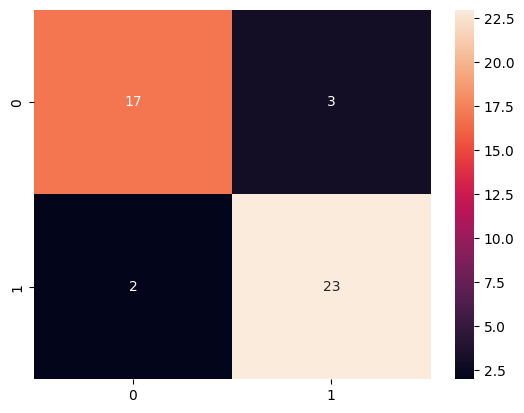

In [20]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm.astype("int"), annot=True)

In [ ]:
# สร้างแบบจำลองใหม่โดยใช้ ResNet50
#base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#base_model.trainable = True  # ทำให้ทุกชั้นของ ResNet50 สามารถฝึกได้

# สร้างสถาปัตยกรรมของแบบจำลอง
#inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
#x = base_model(inputs, training=True)
#x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
#x = layers.Dense(256, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
#outputs = layers.Dense(1, activation="sigmoid")(x)
#model_resnet50 = Model(inputs, outputs)

# คอมไพล์แบบจำลอง
#model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(),
#                      loss='binary_crossentropy',
#                       metrics=['accuracy'])

# ฝึกแบบจำลอง
#history_resnet50 = model_resnet50.fit(train_data,
#                                      epochs=20,
#                                      validation_data=val_data)


In [ ]:
#def plot_loss_curves(history):
#    """
#    Returns separate loss curves for training and validation metrics.
#    """
#    loss = history.history['loss']
#    val_loss = history.history['val_loss']

#    accuracy = history.history['accuracy']
#    val_accuracy = history.history['val_accuracy']

#    epochs = range(len(history.history['loss']))

    # Plot loss
#    plt.figure(figsize=(8, 8))
#    plt.plot(epochs, loss, label='Training Loss')
#    plt.plot(epochs, val_loss, label='Validation Loss')
#    plt.title('Training and Validation Loss')
#    plt.xlabel('Epochs')
#    plt.legend()

    # Plot accuracy
#    plt.figure(figsize=(8, 8))
#    plt.plot(epochs, accuracy, label='Training Accuracy')
#    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
#    plt.title('Training and Validation Accuracy')
#    plt.xlabel('Epochs')
#    plt.legend()

#plot_loss_curves(history_resnet50)

In [ ]:
# ประเมินโมเดลบนชุดข้อมูลทดสอบ
#test_loss, test_accuracy = model_resnet50.evaluate(test_data)
#print(f"Test Loss: {test_loss}")
#print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# ทำนายชุดข้อมูลทดสอบ
#y_pred = model_resnet50.predict(test_data)
#y_pred = tf.math.round(y_pred)  # ปรับให้เป็น 0 หรือ 1

# รวบรวม labels จริงจากชุดข้อมูลทดสอบ
#y_true = np.concatenate([labels for _, labels in test_data], axis=0)

# คำนวณความแม่นยำ
#accuracy = accuracy_score(y_true, y_pred)
#print(f"Accuracy: {accuracy}")

In [ ]:
# สร้างและแสดง confusion matrix
#cm = confusion_matrix(y_true, y_pred)
#plt.figure(figsize=(10, 7))
#sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.title('Confusion Matrix')

# Other modules for performance comparison testing

In [21]:
from tensorflow.keras import layers, models

# สร้างสถาปัตยกรรมของแบบจำลอง
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

# Convolutional layer ชั้นที่ 1
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Convolutional layer ชั้นที่ 2
x = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)

# Add a fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)  # Add a dropout rate of 0.5

# Add a final sigmoid layer for classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model_custom = models.Model(inputs, outputs)

# Model Architecture
To address the specific requirements of our binary classification task, a custom convolutional neural network (CNN) model was designed and implemented. The architecture of this model was constructed to effectively extract and learn features from images, facilitating accurate classification. The model architecture comprises several layers, each serving a distinct purpose in the feature extraction and classification process:

**Input Layer**: The model begins with an input layer designed to receive images of shape 224x224 pixels with 3 color channels. This standardization is crucial for processing images in a uniform manner.

**First Convolutional Layer**: The initial layer of convolution employs 32 filters with a kernel size of 3x3, followed by a ReLU activation function. This layer is aimed at capturing basic patterns such as edges and colors. A subsequent max pooling layer with a pool size of 2x2 reduces the dimensionality, focusing on the most prominent features.

**Second Convolutional Layer**: A second convolutional layer, consisting of 64 filters and a 3x3 kernel, further processes the feature maps from the previous layer. This is again followed by max pooling, enhancing the model's ability to identify more complex features in the images.

**Flattening Layer**: The feature maps are flattened into a one-dimensional vector, preparing the data for the fully connected layers.

**Fully Connected Layer**: A dense layer with 256 neurons and ReLU activation function is employed to learn high-level patterns from the flattened feature maps. A dropout layer with a rate of 0.5 is incorporated to reduce the risk of overfitting by randomly omitting a portion of the neurons during training.

**Output Layer**: The final layer is a dense layer with a single neuron and a sigmoid activation function, designed to output the probability that the image belongs to the target class.

In [22]:
#Optimizer: The Adam optimizer was employed with a learning rate of 0.001. Adam is renowned for its efficiency in gradient descent optimization by adaptively adjusting the learning rate, making it particularly suited for deep learning models where the landscape of the loss function can be highly complex.
#Loss Function: Binary crossentropy was chosen as the loss function. This selection is aligned with the binary nature of our classification task, where the model predicts the likelihood of images belonging to one of two possible classes. Binary crossentropy effectively quantifies the difference between the predicted probabilities and the actual binary labels, guiding the model towards better accuracy.
model_custom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

#Model Training
#The model was trained over 20 epochs, allowing sufficient iterations for the model to learn from the training data progressively. An epoch in this context refers to one complete pass of the training dataset through the model.
history_custom = model_custom.fit(train_data,
                                  epochs=20,
                                  validation_data=val_data)


Epoch 1/20


2024-09-07 05:23:59.714847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-09-07 05:23:59.714911: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-09-07 05:23:59.714921: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-09-07 05:23:59.714930: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-09-07 05:23:59.714939: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-09-07 05:23:59.714947: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-09-07 05:23:59.714955: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-09-07 05:23:59.714963: E 

65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5000 - loss: 1520.3922

2024-09-07 05:24:07.642620: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4122: 4.24417, expected 3.67275
2024-09-07 05:24:07.642676: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4288: 4.37816, expected 3.80674
2024-09-07 05:24:07.642713: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6716: 4.42716, expected 3.85575
2024-09-07 05:24:07.642742: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8503: 4.41161, expected 3.8402
2024-09-07 05:24:07.642765: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9768: 4.50834, expected 3.93692
2024-09-07 05:24:07.642812: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14101: 4.24417, expected 3.67275
2024-09-07 05:24:07.642828: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14267: 4.37816, expected 3.80675
2024-09-07 05:24:07.642878: E ext

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5010 - loss: 1491.0066

2024-09-07 05:24:13.782986: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147863: 4.20057, expected 3.56758
2024-09-07 05:24:13.783041: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148112: 5.2774, expected 4.6444
2024-09-07 05:24:13.783054: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148733: 5.23249, expected 4.59949
2024-09-07 05:24:13.783064: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149184: 4.9994, expected 4.36641
2024-09-07 05:24:13.783073: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149297: 5.27461, expected 4.64162
2024-09-07 05:24:13.783085: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149315: 5.15052, expected 4.51753
2024-09-07 05:24:13.783094: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149353: 5.2018, expected 4.5688
2024-09-07 05:24:13.78310

67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 0.5015 - loss: 1476.9028 - val_accuracy: 0.6310 - val_loss: 0.8866
Epoch 2/20
 3/67 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5625 - loss: 1.9809 

W0000 00:00:1725686654.524958     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5487 - loss: 3.1842 - val_accuracy: 0.4000 - val_loss: 12.5033
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5352 - loss: 1.4690 - val_accuracy: 0.6024 - val_loss: 0.6873
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5456 - loss: 0.6897 - val_accuracy: 0.6024 - val_loss: 0.6857
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5478 - loss: 0.6889 - val_accuracy: 0.6024 - val_loss: 0.6841
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5476 - loss: 0.6888 - val_accuracy: 0.6024 - val_loss: 0.6826
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5621 - loss: 0.6858 - val_accuracy: 0.6024 - val_loss: 0.6813
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5466 - loss: 0.6871 - val_accuracy: 0.6024 - val_loss: 0.6801
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5421 - loss: 0.6891 - val_accuracy: 0.6024 - val_loss: 0

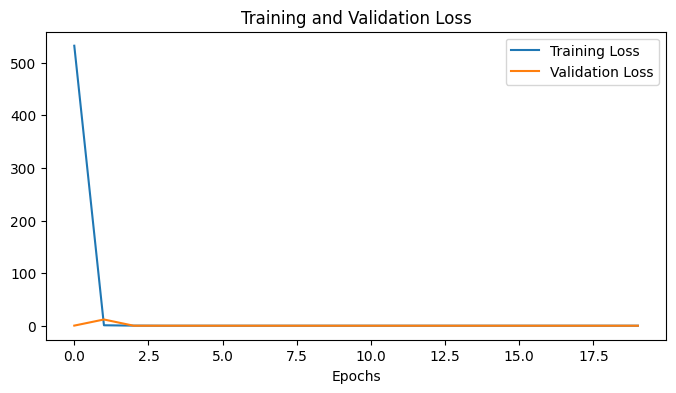

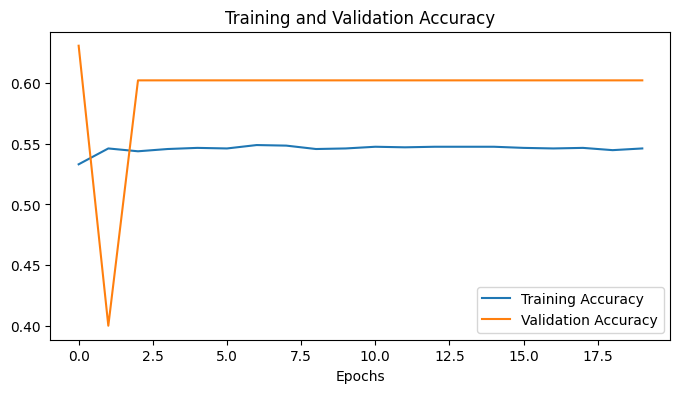

In [23]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history_custom)


# Evaluation of Model Training Dynamics
Visual Analysis of Training and Validation Metrics
To comprehensively assess the performance of the custom convolutional neural network model throughout its training phase, a visualization function, plot_loss_curves, was developed and applied. This function is instrumental in depicting the model's learning progression, facilitating the identification of key training characteristics such as convergence behavior, overfitting, or underfitting.

**Function Overview**
The plot_loss_curves function extracts the training and validation loss and accuracy metrics from the model's training history, provided by TensorFlow's History object. It then generates two separate plots:

**Training and Validation Loss**: The first plot visualizes the loss metrics, with the training loss depicted alongside the validation loss over the course of training epochs. This plot is crucial for observing how the model's performance improves and whether it begins to overfit to the training data by exhibiting an increasing trend in validation loss.

**Training and Validation Accuracy**: The second plot displays the accuracy metrics, plotting both training and validation accuracy. This visualization offers insights into the model's capability to correctly classify the images, highlighting the progression of accuracy and its stabilization or potential divergence, indicative of overfitting or underfitting, respectively.

**Visualization Process**
Upon invocation, plot_loss_curves executes the following steps:

**Metric Extraction**: The function retrieves the loss and accuracy metrics from the History object's history attribute, encompassing both training and validation phases.

**Epoch Enumeration**: It enumerates the epochs based on the length of the loss history, providing a temporal axis for the plots.

**Plot Configuration**: For each metric (loss and accuracy), a separate plot is configured, setting the figure size to 8x8 inches for clarity. The training and validation metrics are plotted as distinct lines, with appropriate labels and legends for differentiation.

**Display**: The plots are titled 'Training and Validation Loss' and 'Training and Validation Accuracy' respectively, with epochs on the x-axis and the metric values on the y-axis. Legends distinguish between training and validation lines, aiding in interpretation.

In [50]:
# ประเมินโมเดลบนชุดข้อมูลทดสอบ
test_loss, test_accuracy = model_custom.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.4954 - loss: 0.6829
Test Loss: 0.6658971309661865
Test Accuracy: 0.5555555820465088


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step

2024-09-07 05:26:50.147609: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.85897, expected 6.06893
2024-09-07 05:26:50.147660: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.96167, expected 5.17163
2024-09-07 05:26:50.147669: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.44264, expected 5.65259
2024-09-07 05:26:50.147678: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 6.23199, expected 5.44195
2024-09-07 05:26:50.147686: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 5.01164, expected 4.22159
2024-09-07 05:26:50.147695: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 5.90012, expected 5.11007
2024-09-07 05:26:50.147703: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 6.65641, expected 5.86637
2024-09-07 05:26:50.147711: E external/local_xla/xl

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  
Accuracy: 0.5555555555555556


Text(0.5, 1.0, 'Confusion Matrix')

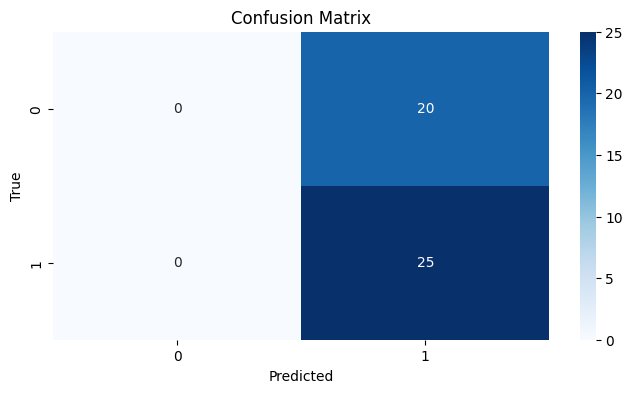

In [24]:
# ทำนายชุดข้อมูลทดสอบและปรับค่าเป็น 0 หรือ 1
y_pred = model_custom.predict(test_data)
y_pred_rounded = tf.round(y_pred)

# รวบรวม labels จริงจากชุดข้อมูลทดสอบ
y_true = np.concatenate([y for x, y in test_data], axis=0)

# คำนวณความแม่นยำ
accuracy = accuracy_score(y_true, y_pred_rounded)
print(f"Accuracy: {accuracy}")

# สร้างและแสดง confusion matrix
cm = confusion_matrix(y_true, y_pred_rounded)
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


# Conclusion

This project has attempted to apply deep learning technology to create models for classification and detection of monkeypox skin lesions using the "Monkeypox Skin Lesion Dataset" from Kaggle. General Convolutional Neural Network (CNN) and EfficientNetB3 were employed to compare the performance of both models in image classification. The results revealed that due to the nature of this image dataset requiring high accuracy in classification, the more complex and suitable model, EfficientNetB3, provided higher accuracy (approximately 89%). Although the standard CNN model could process data faster, it yielded lower accuracy (approximately 60%) for tasks demanding high precision. However, each model is inherently suitable for specific types of datasets, depending on the complexity of the data and the desired outcomes from that dataset.